## Overview

This notebook contains the code for the final ML pipeline that will be deployed for detecting offensive language.

## Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.corpus import stopwords
import contractions
import emoji
import string
from word2number import w2n
from nltk.stem.wordnet import WordNetLemmatizer
import logging
import matplotlib.pyplot as plt
import re
import os
import shutil
import random
tf.get_logger().setLevel('ERROR')

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Set Seed for Reproducibility

In [13]:
# Seed value
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Load Dataset

In [14]:
df = pd.read_table(r'C:\Users\ASUS\Offensive_Language_Detection\Notebooks\olid.txt')
df.head(3)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


### Drop the unwanted columns

In [16]:
df.drop(labels=['id', 'subtask_b', 'subtask_c'], axis = 1, inplace=True)
df.head(3)

,tweet,subtask_a
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT


### Drop Missing Values

In [17]:
df.dropna(axis = 0, how ='any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      13240 non-null  object
 1   subtask_a  13240 non-null  object
dtypes: object(2)
memory usage: 207.0+ KB


### Rename column

In [18]:
df.rename(mapper = {'subtask_a':'label'}, inplace=True, axis = 1)

### Encode the Labels

Because some models expect numeric values for the labels, I will replace **'OFF' with 1** and **'NOT' with 0** 

In [19]:
df['label'] = df['label'].replace(['OFF', 'NOT'], [1, 0])

### Split the Dataset

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.1, random_state=12)

In [21]:
# train_data = pd.merge(X_train, y_train, on = X_train.index).iloc[:,1:]
# test_data = pd.merge(X_test, y_test, on = X_test.index).iloc[:,1:]

In [22]:
# train_data.to_csv('train_data.csv')
# test_data.to_csv('test_data.csv')

## Text Preprocessing

### Define functions that will be used to preprocess the text

In [23]:
#function to expand contractions - contractions.fix()

In [24]:
#function to normalize the text

def lowercase(text):
    
    """ Function_name: normalizer
        input_params:
            text: string
        output_params: text in lowercase
        """
    return text.lower()

In [25]:
#function to remove emojis 

def remove_emoji(text):
    
    """ Function_name: emoji_remover
        input_params:
            text: string
        output_params: text with all emojis removed
        """    
    return emoji.replace_emoji(text,replace='')

In [26]:
#create a function to remove punctuation marks

def remove_punctuation(text):
    
    """ Function_name: punctuation_remover
        input_params:
            text: string
        output_params: text with all punctuation marks removed
        """     
    punctuation_marks = string.punctuation
    return text.translate(str.maketrans('', '', punctuation_marks))

In [27]:
#create function emove url & user

def remove_url_user(text):
    
    """ Function_name: url_remover
        input_params:
            text: string
        output_params: text with all 'urls' & 'user' removed
        """     
    text_1 = text.replace('url','')
    return text_1.replace('user', '')

In [28]:
#function to tokenize text - (word_tokenize())

In [29]:
#convert word to numbers
#nltk_pos_tag for some reason tags certain words as CD e.g girl, so I have to use a tray & except block to handle this 

def convert_to_numeric(lists):
    
    """ Function_name: word2number
        input_params:
            lists: Python list containing strings
        output_params: Python list with all numbers in words converted to digits
        """ 
    
    length = len(lists)
    tags = nltk.pos_tag(lists)
    new_list = []
    for i in range(length):
        if tags[i][1] == 'CD':
            try:
                new_list.append(w2n.word_to_num(lists[i]))
            except:
                new_list.append(lists[i])
        else:
            new_list.append(lists[i])
    return new_list

In [30]:
#function to remove all digits

def remove_numbers(lists):
    
    """ Function_name: digit_remover
        input_params:
            lists: Python list containing strings
        output_params: Python list with all digits removed
        """ 
    new_list = []
    for val in lists:
        if not bool(re.search(r'\d', str(val))):
            new_list.append(val)
    return new_list
     

In [31]:
#function to remove stop words

def remove_stop_words(lists):
    
    """ Function_name: stop_words_remover
        input_params:
            lists: Python list containing strings
        output_params: Python list with all stop words removed
        """ 
    
    stoplist = set(stopwords.words('english'))
    new_list = []
    for word in lists:
        if word not in stoplist:
            new_list.append(word)
    return new_list

In [32]:
#function to lemmatize words

def lemmatize_words(lists):
    
    """ Function_name: lemmatizer
        input_params:
            lists: Python list containing strings
        output_params: Python list with all words lemmatized
        """     
    lemmatizer = WordNetLemmatizer()
    new_list = []
    for word in lists:
        new_list.append(lemmatizer.lemmatize(word))
    return new_list

In [33]:
# function to join elements in the list back into a sentence

def rejoin(lists):
    
    """ Function_name: sentence_maker
        input_params:
            lists: Python list containing strings
        output_params: Python string
        """
    
    return " ".join(lists)
        

### Tokenizer

**The BERT model**

The BERT model I'll be using for this project is DistilBERT, so I'll load the preprocessor & encoder from tensorflowhub

In [34]:
tfhub_preprocess = 'https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2'
tfhub_bert = 'https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1'

bert_tokenizer = hub.KerasLayer(tfhub_preprocess)
bert_encoder = hub.KerasLayer(tfhub_bert, trainable=True)

### Create a Preprocessing Pipeline

In [35]:
#create a pipeline unction to apply all the other functions

def processing_pipeline(text):
    
    new_text = contractions.fix(text)
    new_text = lowercase(new_text)
    new_text = remove_emoji(new_text)
    new_text = remove_punctuation(new_text)
    new_text = remove_url_user(new_text)
    new_text = word_tokenize(new_text)
    new_text = convert_to_numeric(new_text)
    new_text = remove_numbers(new_text)
    new_text = remove_stop_words(new_text)
    new_text = lemmatize_words(new_text)
    new_text = rejoin(new_text)
    
    return new_text
    
    
    

In [36]:
#Preprocess the tweets

In [37]:
X_train = X_train.apply(processing_pipeline)

In [27]:
#Check for empty tweets

In [28]:
sum(X_train == '')

94

**Remove empties**

In [30]:
#get the index of empties
X_empty = X_train[X_train == '']
X_empty_index = X_empty.index

In [32]:
#drop the empty index from training data
X_train = X_train.drop(index = X_empty_index)
y_train = y_train.drop(index = X_empty_index)

In [34]:
X_train_token = bert_tokenizer(X_train)

## Finetune BERT model for Classification

**Generate class_weights**

In [38]:
neg =  y_train.value_counts()[0]
pos =  y_train.value_counts()[1]
total = y_train.shape[0]
weight_for_0 = (1/neg) * (total/2)
weight_for_1 = (1/pos) * (total/2)

#create a dictionary to hold the weights
class_weights = {0:weight_for_0, 1:weight_for_1 }
class_weights

{0: 0.7492454728370221, 1: 1.5030272452068618}

In [39]:
neg, pos

(7952, 3964)

**Set the initial bias**

In [40]:
#get the correct value for the initial bias
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [41]:
metrics = tf.metrics.BinaryAccuracy()
loss=tf.keras.losses.BinaryCrossentropy()


def create_model():
    input_word_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_mask")
    
    encoder = hub.KerasLayer(tfhub_bert, trainable=True, name='BERT_encoder')
    
    encoder_output = encoder({'input_word_ids':input_word_ids, 'input_mask':input_mask},True)
    sequence_output = encoder_output['sequence_output']
    
    clf_output = sequence_output[:, 0, :]

    layer = layers.Dense(units = 64, activation = 'relu', name ='hidden_layer_1')(clf_output)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(32, activation='relu', name = 'hidden_layer_2')(layer)
    out = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(layer)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),loss=loss, metrics=['accuracy'])
    
    return model

**Create the model**

In [41]:
#Create the model
bert_classifier = create_model()
bert_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 BERT_encoder (KerasLayer)      {'encoder_outputs':  66362880    ['input_mask[0][0]',             
                                 [(None, 128, 768),               'input_word_ids[0][0]']         
                                 (None, 128, 768),                                                
                                 (None, 128, 768),                                          

**Fit the model to the training set**

In [45]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = bert_classifier.fit(X_train_token,y_train, epochs = 5,validation_split=0.2, callbacks=[checkpoint], verbose=1, class_weight=class_weights)

Epoch 1/5
296/296 [==============================] - ETA: 0s - loss: 0.5240 - accuracy: 0.7448 
Epoch 1: val_accuracy improved from -inf to 0.78393, saving model to model.h5
296/296 [==============================] - 6306s 21s/step - loss: 0.5240 - accuracy: 0.7448 - val_loss: 0.4602 - val_accuracy: 0.7839
Epoch 2/5
296/296 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.7992 
Epoch 2: val_accuracy did not improve from 0.78393
296/296 [==============================] - 6321s 21s/step - loss: 0.4400 - accuracy: 0.7992 - val_loss: 0.4746 - val_accuracy: 0.7734
Epoch 3/5
296/296 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8390 
Epoch 3: val_accuracy did not improve from 0.78393
296/296 [==============================] - 6328s 21s/step - loss: 0.3687 - accuracy: 0.8390 - val_loss: 0.5236 - val_accuracy: 0.7548
Epoch 4/5
296/296 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.8792 
Epoch 4: val_accuracy did not impr

In [59]:
history = bert_classifier.fit(X_train_token,y_train, epochs = 2,validation_split=0.2, callbacks=[checkpoint], verbose=1, class_weight=class_weights)

Epoch 1/2
296/296 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9443 
Epoch 1: val_accuracy improved from 0.78689 to 0.78732, saving model to model.h5
296/296 [==============================] - 6727s 23s/step - loss: 0.1429 - accuracy: 0.9443 - val_loss: 0.7212 - val_accuracy: 0.7873
Epoch 2/2
296/296 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9589 
Epoch 2: val_accuracy did not improve from 0.78732
296/296 [==============================] - 6311s 21s/step - loss: 0.1085 - accuracy: 0.9589 - val_loss: 0.7778 - val_accuracy: 0.7729


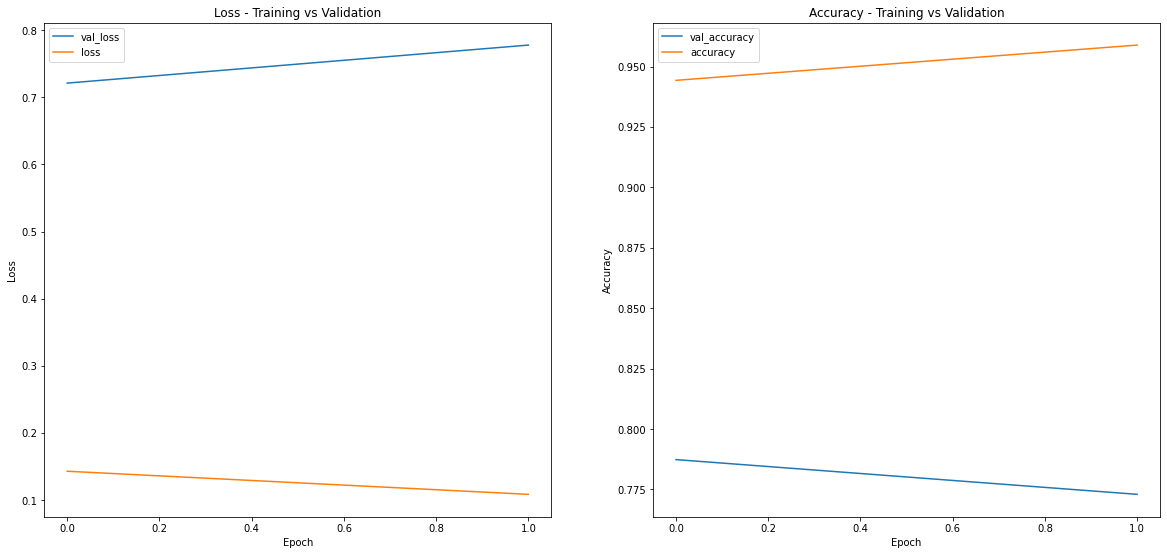

In [60]:
#Plot the learning curves
plt.figure( figsize=(20,20))

plt.subplot(2, 2, 1)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss - Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss','loss'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Accuracy - Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_accuracy','accuracy'], loc='upper left')

plt.show()

In [117]:
bert_classifier.save('saved_model')

### Test the model

**Pre process the test set**

In [47]:
X_test = X_test.apply(processing_pipeline)

In [50]:
X_test_token = bert_tokenizer(X_test)

**Predict the classes for the test set**

In [61]:
#Get the probabilities
pred_proba = bert_classifier.predict(X_test_token)


42/42 [==============================] - 332s 8s/step


In [52]:
#function to convert probabilties to classes
def convert(prediction_array, threshold):
    predictions_list = []
    for val in prediction_array:
        for value in val:
            if value >= threshold:
                predictions_list.append(1)
            else:
                predictions_list.append(0)
    return pd.Series(predictions_list)

def test_results(true_labels, predicted_labels,model_name, dataset):
    
    f1score = f1_score(true_labels, predicted_labels, average = 'macro')
    cm = confusion_matrix(true_labels, predicted_labels)
    per_class = cm.diagonal()/cm.sum(axis=1)
    result = pd.Series({'Model Name': model_name , 'Dataset':dataset,'Macro_F1score':f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()
    return result

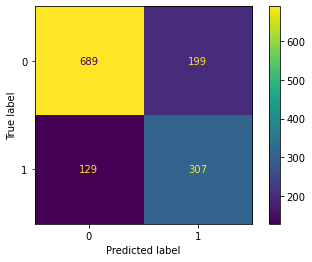

Model Name                                         BERT
Dataset                    Imbalanced with Class Weight
Macro_F1score                                  0.729771
Majority_Class_Accuracy                        0.775901
Minority_Class_Accuracy                        0.704128
dtype: object

In [71]:
prediction = convert(pred_proba,0.4)
bert_result = test_results(y_test, prediction,'BERT', 'Imbalanced with Class Weight')
bert_result

## Deploy Model as REST API

Now that the model has been trained, tested and saved, I will convert this pipeline to production code and deploy the model

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13775 sha256=5fa269cf09d0c31e86a4a4a39ac544cbd016c836da042ee875385aa924d29b9c
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\4e\29\5e\e5f6f558e24e0d70f6808e3e8fdaf2c04ff597233098afc550
Successfully built docopt


In [42]:
loaded_model = tf.keras.models.load_model(r'C:\Users\ASUS\Offensive_Language_Detection\offensive_language_detection_model\saved_model', custom_objects={'KerasLayer':hub.KerasLayer} )

In [45]:
loaded_model.save_weights('saved_weights')

In [46]:
model_b= create_model()

In [59]:
model_b.load_weights('saved_weights')

In [60]:
model_b.save('test_save')

In [63]:
texts = bert_tokenizer(['Fool'])

In [64]:
model_b.predict(texts)

1/1 [==============================] - 0s 223ms/step


array([[0.9864593]], dtype=float32)

In [58]:
new_model.

In [61]:
loaded_m = tf.keras.models.load_model('test_save', custom_objects={'KerasLayer':hub.KerasLayer} )

In [65]:
loaded_m.predict(texts)

1/1 [==============================] - 0s 225ms/step


array([[0.97451144]], dtype=float32)